In [1]:
from qiskit import *  
from time import time #importamos la función time para capturar tiempos
from qiskit.circuit import Parameter 
#librerias para visualizaciones
from qiskit.tools.visualization import plot_state_paulivec
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector
#python
import numpy as np
import matplotlib.pyplot as plt


# Simuladores estandar 
SS = Aer.get_backend('statevector_simulator')
QS = Aer.get_backend('qasm_simulator')

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.1',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.1'}

<h1> Dos spines acoplados </h1>


El Hamiltoniano usado por Ariel en la simulación de la figura 1.b) (del paper: Coding closed and open quantum systems
in MATLAB: applications in quantum
optics and condensed matter) es:
    \begin{eqnarray}
    H = -J \sigma_x^{(1)}\otimes\sigma_x^{(2)}-B(\sigma_x^{(1)}+\sigma_x^{(2)}),
    \end{eqnarray}
es decir, no usa $S_x=\sigma_x/2$ (ver los codigos en el paper). Como todos los operadores de $H$ conmutan no es necesario usar Trotter-Suzuki. La magnetización promedio en $z$ calculada en el paper esta dada por:

\begin{eqnarray}
\langle M_z\rangle = \frac{1}{2}(\langle \sigma_z^{(1)}\rangle + \langle \sigma_z^{(2)}\rangle).
\end{eqnarray}

Consideramos un estado arbitrario $|\psi \rangle$ en el espacio de dos qubits (el cual representa a los dos espines):
\begin{eqnarray}
| \psi \rangle = \alpha | 00 \rangle + \beta | 01\rangle + \gamma |10\rangle + \epsilon |11\rangle.
\end{eqnarray}
Calculando el promedio de $\sigma_z^{(i)}$ en este estado arbitrario obtenemos:
\begin{eqnarray}
\langle\sigma_z^{(1)} \rangle= |\alpha|^2+|\beta|^2-|\gamma|^2-|\epsilon|^2\\
\langle \sigma_z^{(2)} \rangle = |\alpha|^2-|\beta|^2+|\gamma|^2-|\epsilon|^2,\\
\end{eqnarray}
de modo que la magnetización nos queda:
\begin{eqnarray}
\langle M_z\rangle &=& \frac{1}{2}(2|\alpha|^2-2|\epsilon|^2)\\
&=& |\alpha|^2-|\epsilon|^2.
\end{eqnarray}
Dado que $|\alpha|^2$ ($|\epsilon|^2$) es la probabilidad de medir el estado $|00\rangle$ ($|11\rangle$) podemos expresarlos con circuitos cuánticos usando:
\begin{eqnarray}
P_{11} = |\alpha|^2 = \frac{\mbox{N° de veces que se mide 00}}{\mbox{N° total de mediciones}}.
\end{eqnarray}
y lo mismo para $|11\rangle$.

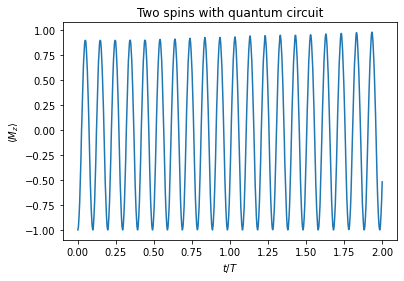

t= 13.28934097290039


In [3]:
# Magnetización vs el tiempo
ti = time()

J = 1
B = 0.1*J
T = np.pi/B
tf = 2*T #hasta aquí, los parametros usados por Ariel para obtener la misma curva
shots = 1024 #el N° total de mediciones
n = 50 #para Trotter-Suzuki
points_t = 1000
t=np.linspace(0,tf,points_t) #vector de tiempo que va de 0 a tf
M_z = np.zeros(points_t) #vector de magnetización, inicialmente todo en 0

for j in range(0,points_t):
    circ = QuantumCircuit(2,2)
    #Condición inicial |down down> == |11>
    circ.x(0)
    circ.x(1) # las dos puertas X nos deja el estado |11>
    
    for i in range(n): # para el Trotter-Suzuki
        circ.rz(-2*B*t[j]/n,0)
        circ.rz(-2*B*t[j]/n,1)# las puertas del operador evolución a tiempo t[j]
        circ.rxx(-2*J*t[j]/(n),0,1) # 
    circ.measure(0,0)
    circ.measure(1,1)

    job = execute(circ, QS, shots = shots, seed_simulator = 1000)
    result = job.result()
    counts = result.get_counts()

   #Magnetización en z
    if '00' in counts:
        M_z[j] += (counts['00']/shots) #probabilidad de medir 00, se suma 
    if '11' in counts:
        M_z[j] -= (counts['11']/shots) #probabilidad de medir 11, se resta
        #Se guarda el M_z[j] resultante a tiempo t[j]      


#Gráfico        
tt = t/T
plt.plot(tt,M_z)
plt.xlabel(r'$t/T$')
plt.ylabel(r'$\langle M_z\rangle $')
plt.title(r'Two spins with quantum circuit')
plt.show()  
        
tf = time()

total = tf-ti
print('t=',total)


## Importante
Tener en consideración que, para Qiskit, las compuertas que estamos usando son así:
#### RXX

$$
        R_{XX}(\theta) = exp(-i \frac{\theta}{2} X{\otimes}X) =
            \begin{pmatrix}
                \cos(\frac{\theta}{2})   & 0           & 0           & -i\sin(\frac{\theta}{2}) \\
                0           & \cos(\frac{\theta}{2})   & -i\sin(\frac{\theta}{2}) & 0 \\
                0           & -i\sin(\frac{\theta}{2}) & \cos(\frac{\theta}{2})   & 0 \\
                -i\sin(\frac{\theta}{2}) & 0           & 0           & \cos(\frac{\theta}{2})
            \end{pmatrix}
$$
Fuente: <https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html>

#### RZ
$$
RZ(\lambda) = exp(-i\frac{\lambda}{2}Z) =
            \begin{pmatrix}
                e^{-i\frac{\lambda}{2}} & 0 \\
                0 & e^{i\frac{\lambda}{2}}
            \end{pmatrix}
$$
Fuente: <https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZGate.html>

## Ahora estudiamos el caso de la evolución para un tiempo determinado 

In [2]:
J = 1
B = 0.1*J
shots = 1024
parameter_theta = Parameter('θ') # -2B*t/n
parameter_phi = Parameter('ϕ') # -2J*t/n
n = 4 # n gives the number of decomposition of the Trotter-Susuki theorem
circ = QuantumCircuit(2,2)
for i in range(n):
    circ.rz(parameter_theta, qubit=0)
    circ.rz(parameter_theta, qubit=1)
    circ.rxx(parameter_phi,qubit1=0,qubit2=1)
    circ.barrier()
#print(circ.parameters)
circ.draw()

┌───────┐┌─────────┐ ░ ┌───────┐┌─────────┐ ░ ┌───────┐┌─────────┐ ░ »
q_0: ┤ RZ(θ) ├┤0        ├─░─┤ RZ(θ) ├┤0        ├─░─┤ RZ(θ) ├┤0        ├─░─»
     ├───────┤│  RXX(ϕ) │ ░ ├───────┤│  RXX(ϕ) │ ░ ├───────┤│  RXX(ϕ) │ ░ »
q_1: ┤ RZ(θ) ├┤1        ├─░─┤ RZ(θ) ├┤1        ├─░─┤ RZ(θ) ├┤1        ├─░─»
     └───────┘└─────────┘ ░ └───────┘└─────────┘ ░ └───────┘└─────────┘ ░ »
c: 2/═════════════════════════════════════════════════════════════════════»
                                                                          »
«     ┌───────┐┌─────────┐ ░ 
«q_0: ┤ RZ(θ) ├┤0        ├─░─
«     ├───────┤│  RXX(ϕ) │ ░ 
«q_1: ┤ RZ(θ) ├┤1        ├─░─
«     └───────┘└─────────┘ ░ 
«c: 2/═══════════════════════
«

In [3]:
t = np.pi*10*1.0
qc = QuantumCircuit(2,2)
qc.x(0)
qc.x(1)
n=40
for i in range(n):
    qc.rz(-2*B*t/n, qubit=0)
    qc.rz(-2*B*t/n, qubit=1)
    qc.rxx(-2*J*t/n,qubit1=0,qubit2=1)
qc.measure(0,0)
qc.measure(1,1)
#qc.measure_all()
job = execute(qc,QS,shots = shots,seed = 1000)
result = job.result()   

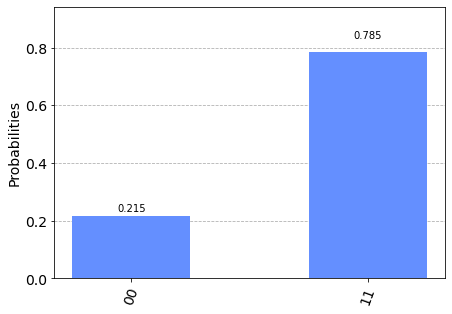

In [5]:
counts = result.get_counts() #para obtener el conteo de mediciones
plot_histogram(counts)


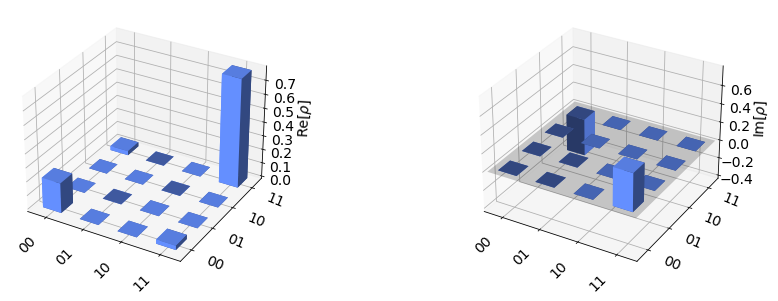

In [7]:
t = np.pi*10*1.0
qc2 = QuantumCircuit(2,2)
qc2.x(0)
qc2.x(1)
n=40
for i in range(n):
    qc2.rz(-2*B*t/n, qubit=0)
    qc2.rz(-2*B*t/n, qubit=1)
    qc2.rxx(-2*J*t/n,qubit1=0,qubit2=1)
job2 = execute(qc2,SS,shots = shots, seed= 1000)
result2 = job2.result()
state_vector = result2.get_statevector() #para obtener el estado 
#plot_state_paulivec(state_vector)
plot_state_city(state_vector)
#plot_bloch_multivector(state_vector)

In [7]:
#param_dict = {Parameter('θ'): 3.1416/4, Parameter('ϕ'):0.1}
#print(param_dict)
#bound_circ = circ.bind_parameters({1/1000, 1/8})
#bound_circ.draw('mpl')


NameError: name 'assign' is not defined

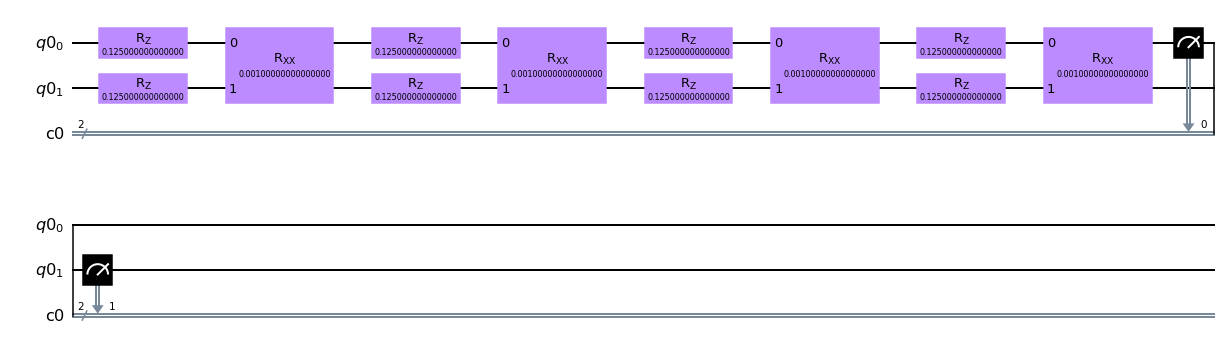

In [41]:
bound_circuit.measure(0,0)
bound_circuit.measure(1,1)
bound_circuit.draw('mpl')